We will try to fit the following model

<img src="../meetings/10_16/model.jpg" />

We'll try to model something relatively close to the 88 soils example

So we'll let the unobserved variables $\beta_0=16$ , $\beta_1 = -3$, and $\Lambda = \begin{bmatrix}1\\ \vdots \\-1\end{bmatrix}$.

The we'll let the observed variable $g_j \in [3, 9]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, multinomial, multivariate_normal
from skbio.stats.composition import clr
%matplotlib inline

In [2]:
num_samples = 20
num_features = 32
rank = 2**3 - 1
gradient = np.linspace(0, 10, num_samples)
mu = np.linspace(0, 10, num_features)
sigma = 2
xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
      for i in range(len(mu))]
table = np.vstack(xs).T
table = pd.DataFrame(table)
table.index = table.index.astype(np.str)
table.columns = table.columns.astype(np.str)

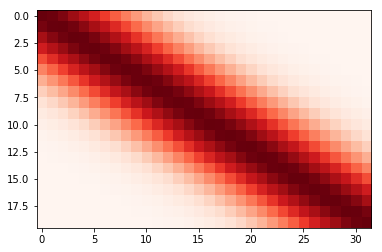

In [3]:
plt.imshow(table.values, aspect='auto', interpolation='nearest', cmap='Reds')

In [4]:
from gneiss.cluster import rank_linkage
x = pd.Series(np.arange(num_features))
x.index = x.index.astype(np.str)
tree = rank_linkage(x)

In [5]:
#print(tree.ascii_art())

In [6]:
from gneiss.composition import ilr_transform
balances = ilr_transform(table, tree)

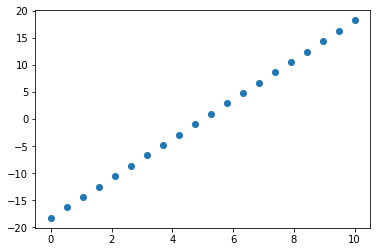

In [7]:
plt.scatter(gradient, balances.y0)

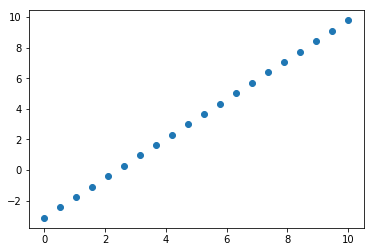

In [8]:
plt.scatter(gradient, balances.y1)

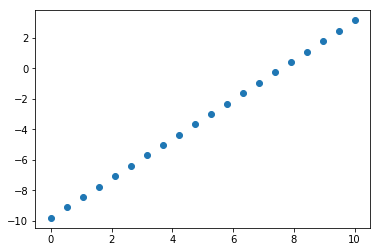

In [9]:
plt.scatter(gradient, balances.y2)

In [10]:
def ols(Y, X):
    n, p = X.shape
    inv = np.linalg.pinv(np.dot(X.T, X))
    cross = np.dot(inv, X.T)
    beta = np.dot(cross, Y)
    pY = np.dot(X, beta)
    resid = (Y - pY)
    sst = (Y - Y.mean(axis=0))
    sse = (resid**2).sum(axis=0)

    sst_balance = ((Y - Y.mean(axis=0))**2).sum(axis=0)

    sse_balance = (resid**2).sum(axis=0)
    ssr_balance = (sst_balance - sse_balance)

    df_resid = n - p + 1
    mse = sse / df_resid
    # t tests
    cov = np.linalg.pinv(np.dot(X.T, X))
    return pY, resid, beta, cov

In [11]:
Y = balances.values
X = gradient.reshape(-1, 1)
X = np.hstack((np.ones(len(X)).reshape(-1, 1), X.reshape(-1, 1)))
pY, resid, beta, cov = ols(Y, X)

In [12]:
beta0 = np.ravel(beta[0, :]).reshape(-1, 1)
beta1 = np.ravel(beta[1, :]).reshape(-1, 1)

In [13]:
from numpy.random import multivariate_normal, multinomial
from gneiss.balances import balance_basis
from gneiss.util import band_diagonal
from skbio.stats.composition import ilr_inv
from scipy.stats import invwishart

r = len(beta0)
up = 0.5
I = np.eye(r)
sigma = invwishart.rvs(df=r+1, scale=I)

y = X.dot(beta)
Ys = np.vstack([multivariate_normal(y[i, :], sigma) for i in range(y.shape[0])])
basis, _ = balance_basis(tree)
Yp = ilr_inv(Ys, basis)

N = 1000   # sampling depth
Yc = np.vstack(multinomial(N, Yp[i, :]) for i in range(y.shape[0]))

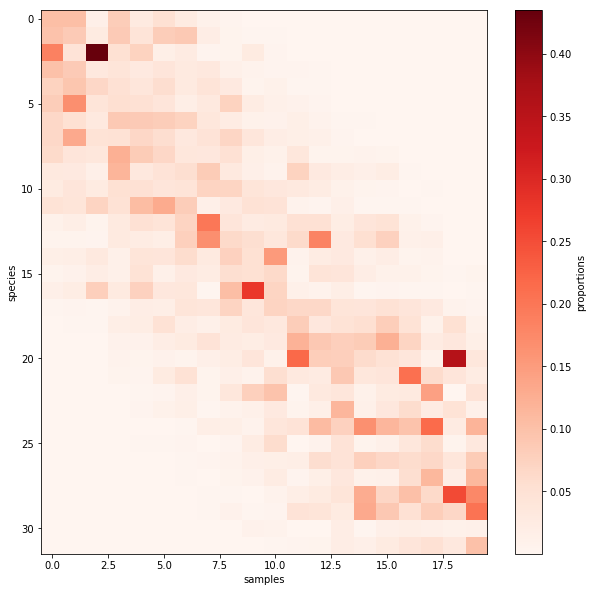

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(Yp.T, aspect='auto', interpolation='nearest', cmap='Reds')
plt.colorbar(label='proportions')
plt.ylabel('species')
plt.xlabel('samples')

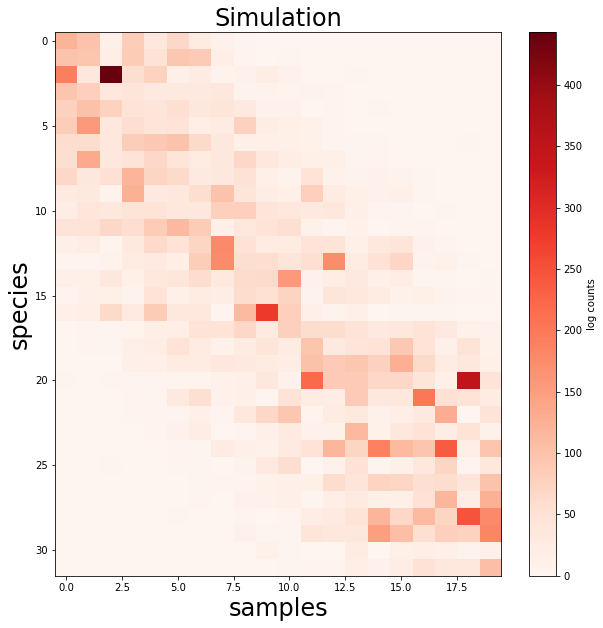

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(Yc.T, aspect='auto', interpolation='nearest', cmap='Reds')
plt.colorbar(label='log counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24)

In [16]:
np.savetxt('sim.txt', Yc)